In [ ]:
import pandas as pd

Abrimos el dataset con datos de videojuegos y el número de ventas. Analizamos la composición de cada atributo

In [ ]:
games_data = pd.read_csv('https://gist.githubusercontent.com/zhonglism/f146a9423e2c975de8d03c26451f841e/raw/f79e190df4225caed58bf360d8e20a9fa872b4ac/vgsales.csv')

In [ ]:
games_data.columns

Index(['Rank', 'Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'],
      dtype='object')

In [ ]:
for col in games_data.columns:
  valcounts = games_data[col].value_counts()
  print(col+'\n')
  print(valcounts)
  print(str(len(valcounts))+'\n')

Rank

2047     1
10864    1
6822     1
677      1
2724     1
        ..
1354     1
7497     1
5448     1
11583    1
2049     1
Name: Rank, Length: 16598, dtype: int64
16598

Name

Need for Speed: Most Wanted        12
Ratatouille                         9
Madden NFL 07                       9
LEGO Marvel Super Heroes            9
FIFA 14                             9
                                   ..
Dragon Ball Z: La Legende Saien     1
Armored Core: Project Phantasma     1
The Guided Fate Paradox             1
Counter-Strike: Source              1
Jampack Summer '99                  1
Name: Name, Length: 11493, dtype: int64
11493

Platform

DS      2163
PS2     2161
PS3     1329
Wii     1325
X360    1265
PSP     1213
PS      1196
PC       960
XB       824
GBA      822
GC       556
3DS      509
PSV      413
PS4      336
N64      319
SNES     239
XOne     213
SAT      173
WiiU     143
2600     133
GB        98
NES       98
DC        52
GEN       27
NG        12
WS         6
SCD    

Vamos a quedarnos con Plataforma, Genero, Año y Publisher. Sin embargo, hay demasiadas posibles categorías para plataforma y publisher. Nos quedaremos con las más frecuentes y las demás las asignamos a Other.

In [ ]:
len(games_data['Publisher'].unique())

579

In [ ]:
publisher_counts = games_data['Publisher'].value_counts(normalize=True)
valid_publishers = publisher_counts[publisher_counts>0.02].index

platform_counts = games_data['Platform'].value_counts(normalize=True)
valid_platforms = platform_counts[platform_counts>0.02].index

In [ ]:
games_data['Platform'][~games_data['Platform'].isin(valid_platforms)] = 'Other'
games_data['Publisher'][~games_data['Publisher'].isin(valid_publishers)] = 'Other'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
games_data['Platform'].value_counts(normalize=True)

DS       0.130317
PS2      0.130196
Other    0.091939
PS3      0.080070
Wii      0.079829
X360     0.076214
PSP      0.073081
PS       0.072057
PC       0.057838
XB       0.049645
GBA      0.049524
GC       0.033498
3DS      0.030666
PSV      0.024883
PS4      0.020243
Name: Platform, dtype: float64

One hot encoding:

In [ ]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
encoded = ohe.fit_transform(games_data[['Genre','Platform','Publisher']])

In [ ]:
encoded.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
ohe.categories_

[array(['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle',
        'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports',
        'Strategy'], dtype=object),
 array(['3DS', 'DS', 'GBA', 'GC', 'Other', 'PC', 'PS', 'PS2', 'PS3', 'PS4',
        'PSP', 'PSV', 'Wii', 'X360', 'XB'], dtype=object),
 array(['Activision', 'Atari', 'Capcom', 'Electronic Arts',
        'Konami Digital Entertainment', 'Namco Bandai Games', 'Nintendo',
        'Other', 'Sega', 'Sony Computer Entertainment', 'THQ',
        'Take-Two Interactive', 'Tecmo Koei', 'Ubisoft'], dtype=object)]

In [ ]:
encoded.toarray().shape

(16598, 41)

In [ ]:
year_vector = games_data['Year'].values[:,np.newaxis]

In [ ]:
year_vector.shape

(16598, 1)

Chequeo si tengo nans

In [ ]:
np.isnan(year_vector)

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [ ]:
np.sum(np.isnan(year_vector))

271

Puedo reemplazar los nans por el valor promedio de ese atributo:

In [ ]:
from sklearn.impute import SimpleImputer 

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
year_vector = imp.fit_transform(year_vector)

In [ ]:
np.sum(np.isnan(year_vector))

0

Armo los atributos y target

In [ ]:
x_data = np.concatenate([year_vector,encoded.toarray()],axis=1)

In [ ]:
y_data = (games_data['Global_Sales']>0.2).astype(int).values

Entreno el árbol de decisión y lo grafico

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

dt = DecisionTreeClassifier(ccp_alpha=0.003)
dt.fit(x_data,y_data)

DecisionTreeClassifier(ccp_alpha=0.003, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
featnames = ['year'] + list(ohe.get_feature_names())

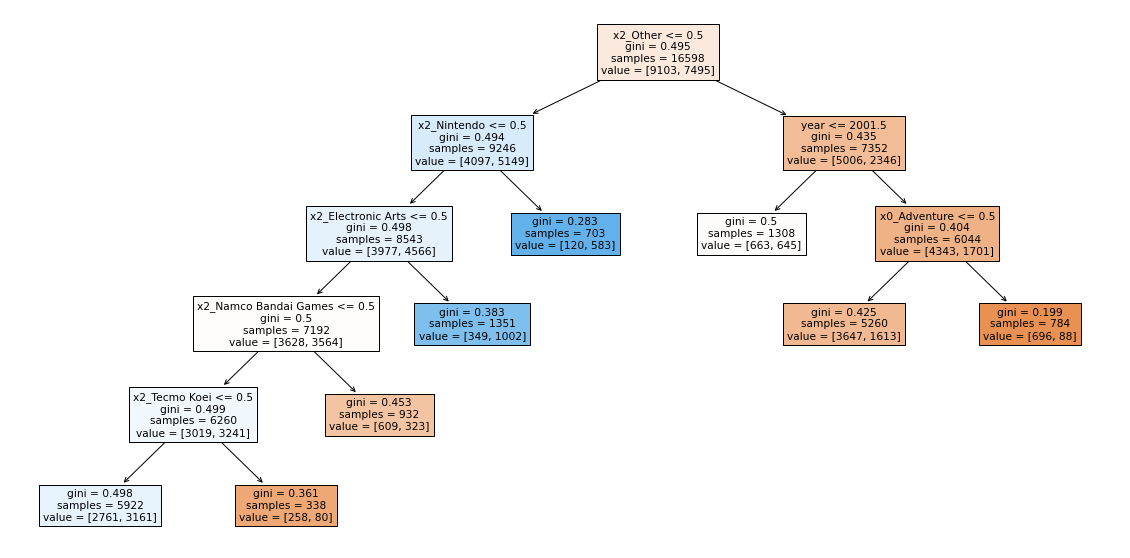

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(dt,feature_names=featnames,filled=True);

### H2O para manejo de variables categóricas y missing values.

H2O no viene incluido en colab asi que lo instalamos con pip

In [ ]:
!pip install h2o

     |████████████████████████████████| 164.8MB 42kB/s 
  Created wheel for h2o: filename=h2o-3.32.1.2-py2.py3-none-any.whl size=164848811 sha256=7adcc3addf18fd8acdd868cb2ddc82d34cbd822eaf14fde6e8f8442f2327d8bb
  Stored in directory: /root/.cache/pip/wheels/37/b6/c7/c1cfdcd471d476b2b5129f4d27a0fd89043858ee74eda7ee7a
Successfully built h2o


Inicializar H2O

In [ ]:
import h2o
from h2o.estimators import H2ORandomForestEstimator

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.11" 2021-04-20; OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04); OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp5zahndjg
  JVM stdout: /tmp/tmp5zahndjg/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp5zahndjg/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.2
H2O_cluster_version_age:,18 days
H2O_cluster_name:,H2O_from_python_unknownUser_9mdnx2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.174 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Los datos se manejan en H2OFrames, estructuras muy similares a los DataFrames de Pandas

In [ ]:
#data_h2o = h2o.import_file('vgsales.csv')
data_h2o = h2o.H2OFrame(games_data)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [ ]:
data_h2o

Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
1,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
2,Super Mario Bros.,Other,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33
5,Pokemon Red/Pokemon Blue,Other,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1,31.37
6,Tetris,Other,1989,Puzzle,Nintendo,23.2,2.26,4.22,0.58,30.26
7,New Super Mario Bros.,DS,2006,Platform,Nintendo,11.38,9.23,6.5,2.9,30.01
8,Wii Play,Wii,2006,Misc,Nintendo,14.03,9.2,2.93,2.85,29.02
9,New Super Mario Bros. Wii,Wii,2009,Platform,Nintendo,14.59,7.06,4.7,2.26,28.62
10,Duck Hunt,Other,1984,Shooter,Nintendo,26.93,0.63,0.28,0.47,28.31


Generar target:

In [ ]:
data_h2o['Global_Sales'] = data_h2o['Global_Sales']>0.2

Indicar las variables que deben ser tratadas como categoricas:

In [ ]:
data_h2o['Platform'] = data_h2o['Platform'].asfactor()
data_h2o['Genre'] = data_h2o['Genre'].asfactor()
data_h2o['Publisher'] = data_h2o['Publisher'].asfactor()
data_h2o['Global_Sales'] = data_h2o['Global_Sales'].asfactor()

Armamos variables indicando qué columnas son atributos y cuál la variable a predecir

In [ ]:
predictores = ['Genre','Publisher','Platform','Year']
target = 'Global_Sales'

H2O no tiene una clase para árboles de decisión. Sin embargo, un random forest de un sólo árbol (ntrees), que toma utiliza todos los atributos (mtries) para construir los árboles, es equivalente a un árbol de decisión.

In [ ]:
h2o_tree = H2ORandomForestEstimator(
        model_id="games",
        ntrees=1,
        mtries=4,
        max_depth=5)

Podemos facilmente armar splits:

In [ ]:
train_frame, test_frame = data_h2o.split_frame(ratios=[0.75])

Al entrenar mandamos el H2OFrame junto a los nombres de las columnas de atributos y las del target.

In [ ]:
h2o_tree.train(x=predictores,y=target,training_frame=train_frame)

drf Model Build progress: |███████████████████████████████████████████████| 100%


Podemos obtener un reporte muy completo de la performance:

In [ ]:
performance = h2o_tree.model_performance(test_data=test_frame)

In [ ]:
performance


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.20537410062758368
RMSE: 0.45318219363472756
LogLoss: 0.5979504911006783
Mean Per-Class Error: 0.3363891842624942
AUC: 0.735675808317461
AUCPR: 0.7020327415078818
Gini: 0.4713516166349221

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33663368225097656: 


,,0,1,Error,Rate
0,0,1122.0,1148.0,0.5057,(1148.0/2270.0)
1,1,335.0,1550.0,0.1777,(335.0/1885.0)
2,Total,1457.0,2698.0,0.3569,(1483.0/4155.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.336634,0.676413,21.0
1,max f2,0.142857,0.808720,28.0
2,max f0point5,0.558621,0.648938,15.0
3,max accuracy,0.558621,0.676775,15.0
4,max precision,1.000000,1.000000,0.0
5,max recall,0.104167,1.000000,29.0
6,max specificity,1.000000,1.000000,0.0
7,max absolute_mcc,0.558621,0.343850,15.0
8,max min_per_class_accuracy,0.466413,0.544053,18.0
9,max mean_per_class_accuracy,0.505155,0.663611,17.0



Gains/Lift Table: Avg response rate: 45.37 %, avg score: 45.10 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.043321,0.931408,1.934836,1.934836,0.877778,0.941380,0.877778,0.941380,0.083820,0.083820,93.483643,93.483643,0.074128
1,2,0.065463,0.863946,1.964652,1.944921,0.891304,0.863946,0.882353,0.915189,0.043501,0.127321,96.465229,94.492120,0.113224
2,3,0.137184,0.773171,1.686469,1.809800,0.765101,0.790187,0.821053,0.849837,0.120955,0.248276,68.646859,80.980036,0.203342
3,4,0.151143,0.658537,1.406156,1.772521,0.637931,0.695860,0.804140,0.835616,0.019629,0.267905,40.615568,77.252108,0.213719
4,5,0.211552,0.626566,1.466569,1.685156,0.665339,0.628792,0.764505,0.776557,0.088594,0.356499,46.656874,68.515585,0.265309
5,6,0.331167,0.558621,1.272873,1.536243,0.577465,0.585723,0.696948,0.707630,0.152255,0.508753,27.287331,53.624275,0.325053
6,7,0.604332,0.466413,1.004048,1.295685,0.455507,0.469083,0.587814,0.599804,0.274271,0.783024,0.404772,29.568466,0.327077
7,8,0.722262,0.296089,0.751242,1.206789,0.340816,0.318018,0.547484,0.553794,0.088594,0.871618,-24.875765,20.678872,0.273380
8,9,0.858243,0.213098,0.526678,1.099031,0.238938,0.220867,0.498598,0.501045,0.071618,0.943236,-47.332222,9.903138,0.155571
9,10,0.902286,0.206897,0.505892,1.070078,0.229508,0.206897,0.485463,0.486687,0.022281,0.965517,-49.410793,7.007846,0.115738


Tambien podemos obtener la importancia de los atributos.

In [ ]:
h2o_tree.varimp

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  games


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,1.0,1.0,460.0,5.0,5.0,5.0,32.0,32.0,32.0




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.203299518224292
RMSE: 0.45088747845143357
LogLoss: 0.5912854007033922
Mean Per-Class Error: 0.32954317424977186
AUC: 0.7380833647869357
AUCPR: 0.6999208191001155
Gini: 0.4761667295738714

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36567163467407227: 


,,0,1,Error,Rate
0,0,1314.0,1174.0,0.4719,(1174.0/2488.0)
1,1,378.0,1641.0,0.1872,(378.0/2019.0)
2,Total,1692.0,2815.0,0.3444,(1552.0/4507.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.365672,0.678941,19.0
1,max f2,0.172414,0.810081,27.0
2,max f0point5,0.551724,0.641403,16.0
3,max accuracy,0.551724,0.675394,16.0
4,max precision,1.000000,1.000000,0.0
5,max recall,0.104167,1.000000,28.0
6,max specificity,1.000000,1.000000,0.0
7,max absolute_mcc,0.365672,0.350105,19.0
8,max min_per_class_accuracy,0.466413,0.543006,18.0
9,max mean_per_class_accuracy,0.365672,0.670457,19.0



Gains/Lift Table: Avg response rate: 45.09 %, avg score: 16.15 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.015189,0.931408,2.030236,2.030236,0.915344,0.940301,0.915344,0.940301,0.030838,0.030838,103.023607,103.023607,0.028496
1,2,0.022583,0.863946,1.856373,1.973313,0.836957,0.863946,0.889680,0.915302,0.013725,0.044563,85.637255,97.331278,0.040026
2,3,0.047416,0.773171,1.665297,1.811996,0.750809,0.792114,0.816949,0.850785,0.041355,0.085918,66.529718,81.199613,0.070112
3,4,0.052479,0.658537,1.619495,1.793424,0.730159,0.674959,0.808576,0.833822,0.008200,0.094118,61.949467,79.342402,0.075824
4,5,0.115406,0.558621,1.320038,1.535303,0.595147,0.599119,0.692201,0.705847,0.083066,0.177184,32.003788,53.530330,0.112498
5,6,0.219400,0.466413,1.026727,1.294242,0.462906,0.468581,0.583516,0.593384,0.106774,0.283957,2.672653,29.424164,0.117559
6,7,0.308527,0.213098,0.628001,1.101780,0.283138,0.262285,0.496744,0.497737,0.055971,0.339929,-37.199899,10.177984,0.057183
7,8,1.000000,0.000000,0.954587,1.000000,0.430381,0.011511,0.450856,0.161525,0.660071,1.000000,-4.541292,0.000000,0.000000




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2021-05-17 21:00:22,0.138 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2021-05-17 21:00:22,0.521 sec,1.0,0.450887,0.591285,0.738083,0.699921,2.030236,0.344353



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Publisher,304.731567,1.000000,0.610509
1,Platform,129.720581,0.425688,0.259886
2,Genre,38.257980,0.125546,0.076647
3,Year,26.433399,0.086743,0.052958


<bound method ModelBase.varimp of >

Por último, con un poco de hacking es posible visualizar el árbol de decisión.

--2021-05-17 21:03:19--  http://h2o-release.s3.amazonaws.com/h2o/rel-zahradnik/4/h2o-3.30.0.4.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.9.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.9.67|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.30.0.4.zip


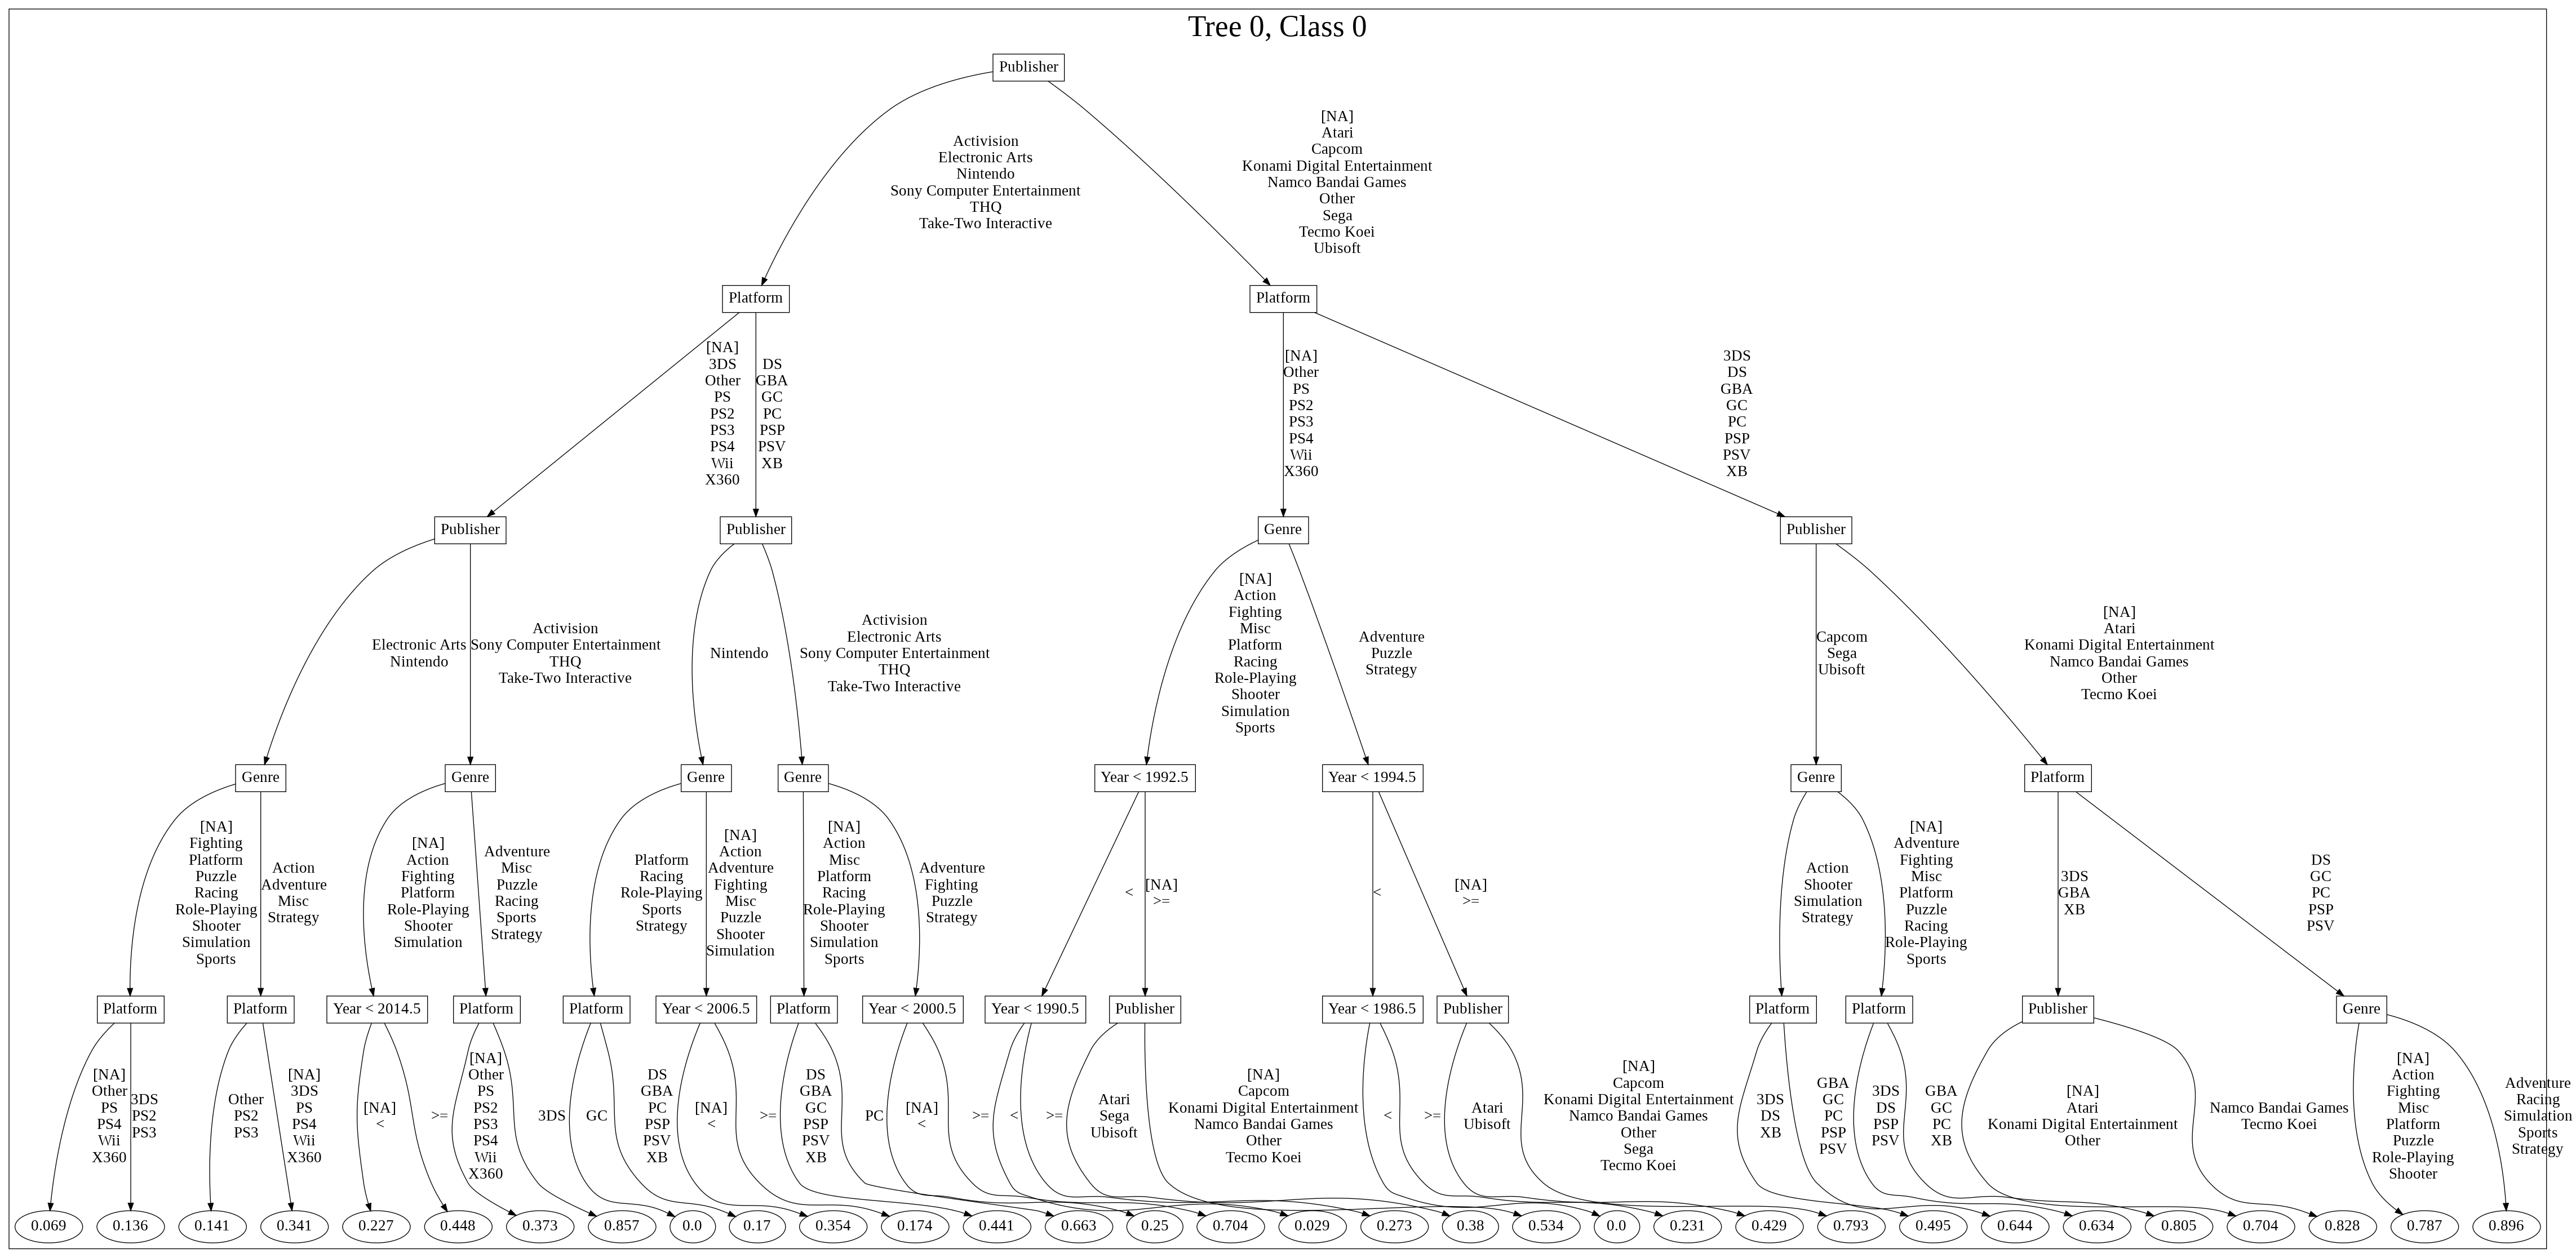

<Figure size 1440x1440 with 0 Axes>

In [ ]:
# download h2o jar 
model_path = h2o_tree.download_mojo(get_genmodel_jar=True,path='miarbol.model')

!wget -c http://h2o-release.s3.amazonaws.com/h2o/rel-zahradnik/4/h2o-3.30.0.4.zip
!unzip -n h2o-3.30.0.4.zip 

!java -cp h2o-3.30.0.4/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv -f 20 -d 3
!dot -Tpng model.gv -o model.png

from IPython.display import display
from PIL import Image

# showing the image in notebook
plt.figure(figsize=(20,20))
display(Image.open('model.png'))